# Chest X-Ray Images (Pneumonia) 

GCS path for pneumonia dataset :
`gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325`

(To check all normal cases within dataset of validation for example, try: ```!gsutil ls gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL```) 

In [1]:
#@title test on gcs path
# expect 8 files
!gsutil ls gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL

gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg


# Set up 

Load data, import libraries and declare useful variables 

In [2]:
#@title import libs 
import numpy as np 
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt 
import cv2 
import pickle 
import gc
import time 
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
    %tensorflow_version 2.x
import tensorflow as tf 
#import tf.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import  Model 
import tensorflow.keras.models as Model
from tensorflow.keras.layers import Input, Dense,Lambda, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.image import per_image_standardization

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#@title TPU detection 
## TPUClusterResolver() automatically detects a connected TPU on all Gooogle's platforms: Colaboratory, AI Platform (ML Engine), Kubernetes, Kaggle, ...

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

except ValueError:
  tpu = None

# TPUStrategy for distributed training
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else: # default strategy that works on CPU and single GPU
  strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)



Running on TPU  ['10.93.142.146:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.93.142.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.142.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [0]:
#@title Configuration
GCS_PATH = 'gs://kds-c78e8837b16c25d554237cd0901977c825714b32059b6b20b94a5325'
GCS_PATTERN_TEST = GCS_PATH + '/chest_xray/test/*/*.jpeg'
GCS_PATTERN_VAL = GCS_PATH + '/chest_xray/val/*/*.jpeg'
GCS_PATTERN_TRAIN = GCS_PATH + '/chest_xray/train/*/*.jpeg'
GCS_PATTERN_TRAIN_N = GCS_PATH + '/chest_xray/train/NORMAL/*.jpeg'
GCS_PATTERN_TRAIN_P = GCS_PATH + '/chest_xray/train/PNEUMONIA/*.jpeg'

VALIDATION_SPLIT = 0.02
BATCH_SIZE = 128 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10
IMAGE_SIZE = [192, 192]
CLASSES = ['PNEUMONIA', 'NORMAL']
DROPOUT = 0.5

GM_EXP = 3.0 # useful for function generalized_mean_pool_2d

In [0]:
#@title Useful functions for loading and plotting
def decode_jpeg_and_label(filename):
    bits = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(bits, channels = 3 )
    img = per_image_standardization(img) 
    img = tf.image.resize(img, [*IMAGE_SIZE]) #resize image

    # parse name from containing directory
    label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
    label = label.values[-2]

    return img, int(label=='PNEUMONIA')+0

#transform test dataset into numpy format 
def dataset_to_numpy_util(dataset):
    numpy_images =   []
    numpy_labels =   []
    for images, labels in dataset:
      numpy_images.append(images.numpy())
      numpy_labels.append(labels.numpy())

    return np.array(numpy_images), numpy_labels


def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13,13))
    subplot=331
    for i, (image, label) in enumerate(dataset):
        plt.subplot(subplot)
        plt.axis('off')
        if image.numpy().shape[2] == 1:
            image = image.numpy().reshape(image.numpy().shape[:2] )
            plt.imshow(image)
        else: 
            plt.imshow(image.numpy().astype(np.uint8))
        plt.title(str(int(label)), fontsize=16)
        subplot += 1
        if i==8:
            break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

#Plot model result
def plot_history(history, variables, pathname, nrow = 1, ncol = 3):
    # Plot loss and Accuracy 
    fig, ax = plt.subplots(nrow, ncol, figsize = (8*ncol,8*nrow))
    df = pd.DataFrame(history)
    ax[0].plot(df[['loss','val_loss']])
    ax[0].set_ylim(0, 5)
    ax[0].set_title('Loss')
    ax[0].legend(['train_loss','val_loss'],
                loc='upper right')
    ax[0].grid()
    fig.savefig('loss')
    
    for i in range(len(variables)):
        tmp = str(variables[i])
        val_tmp = 'val_' + tmp 
    
        ax[i+1].plot(df[[tmp,val_tmp]])
        ax[i+1].set_ylim(0.2, 1.05)
        ax[i+1].set_title(tmp)
        ax[i+1].legend([tmp,val_tmp],
                     loc='lower right')
        ax[i+1].grid()
        fig.savefig(pathname)

In [0]:
#@title Load data (all datasets)
AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

# test 
test_filenames = tf.data.Dataset.list_files(GCS_PATTERN_TEST)
test_dataset = test_filenames.map(decode_jpeg_and_label)

# val 
val_filenames = tf.data.Dataset.list_files(GCS_PATTERN_VAL)
val_dataset = val_filenames.map(decode_jpeg_and_label)
#val_dataset = val_dataset.cache()

#train
train_filenames = tf.data.Dataset.list_files(GCS_PATTERN_TRAIN)
training_dataset = test_filenames.map(decode_jpeg_and_label)
#training_dataset = training_dataset.cache()


In [7]:
#@title Sanity check on image dimensions 
for (i,j) in test_dataset.take(5):
    print(i.numpy().shape, ' ', j)

(192, 192, 3)   tf.Tensor(1, shape=(), dtype=int32)
(192, 192, 3)   tf.Tensor(1, shape=(), dtype=int32)
(192, 192, 3)   tf.Tensor(1, shape=(), dtype=int32)
(192, 192, 3)   tf.Tensor(1, shape=(), dtype=int32)
(192, 192, 3)   tf.Tensor(0, shape=(), dtype=int32)


In [0]:
#@title Prepare dataset in batches
train_dataset = training_dataset.shuffle(10000).batch(BATCH_SIZE)
validation_dataset = val_dataset.batch(BATCH_SIZE)

In [9]:
#@title Transform test dataset into numpy format for later prediction

imgs, classes = dataset_to_numpy_util(test_dataset)
print('preparation done for test dataset')

preparation done for test dataset


# plot (optional)

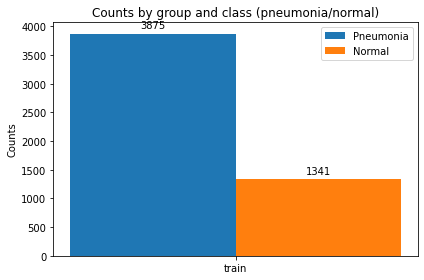

In [10]:
#@title Count values in train dataset

training_filenames_P = tf.io.gfile.glob(GCS_PATTERN_TRAIN_P)
training_filenames_N = tf.io.gfile.glob(GCS_PATTERN_TRAIN_N)
labels = ['train']
pneumonia = [len(training_filenames_P)]
normal = [len(training_filenames_N)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pneumonia, width, label='Pneumonia')
rects2 = ax.bar(x + width/2, normal, width, label='Normal')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by group and class (pneumonia/normal)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

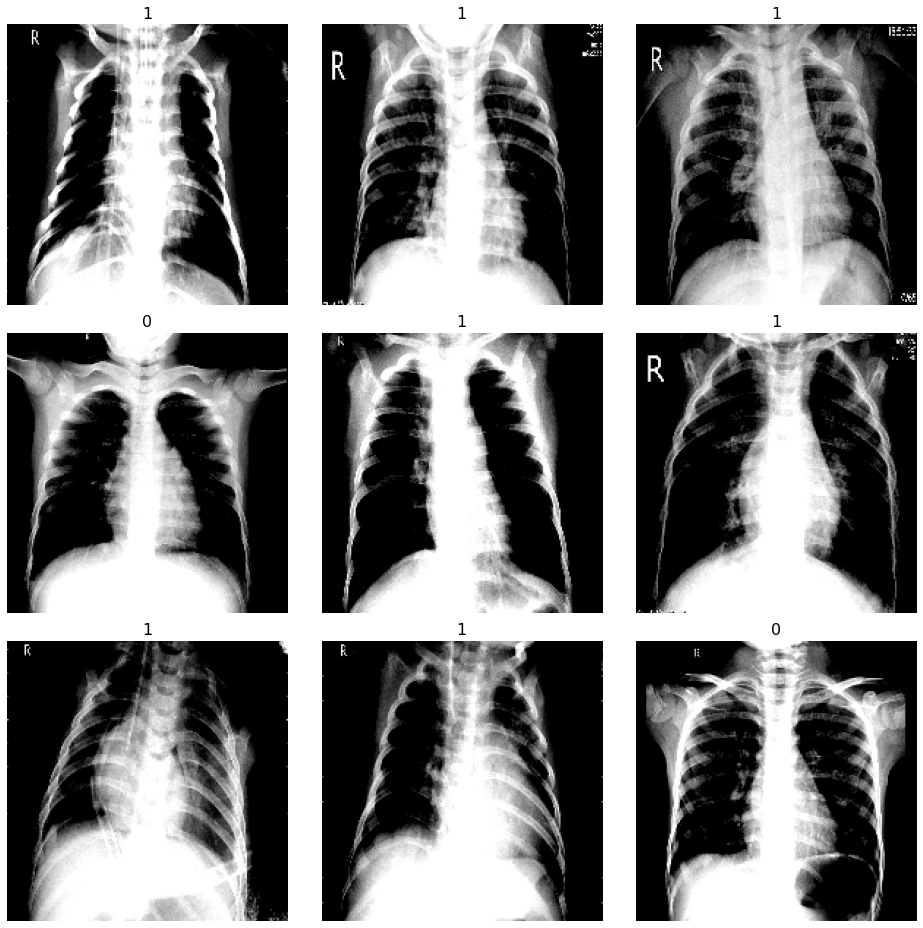

In [11]:
display_9_images_from_dataset(test_dataset)

# Model

In [0]:
#@title Functions of metric and model

def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(GM_EXP)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./GM_EXP)
    return pool


def TPU_VGG19():
    pretrained_model = tf.keras.applications.VGG19(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True


    model = tf.keras.Sequential([
        pretrained_model,
        #Dropout(DROPOUT),
        Lambda(generalized_mean_pool_2d, name = 'GeM'),
        Dense(16, activation = 'relu', name = 'before_y'),
        Dense(1, activation = 'sigmoid', name = 'output_y')
    ])
    return model 

In [13]:
#@title Train

#Create a path on drive to save histories in pickle format
path = '/content/drive/My Drive/kaggle/Pneumonia/tpu_models/final2'

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)


#Model train
start = time.time()
# use TPUStrategy scope to define model
with strategy.scope():
    model = TPU_VGG19()
    model. compile(optimizer = Adam(learning_rate = 0.00005),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
    
history = model.fit(train_dataset, epochs = EPOCHS, 
                    validation_data = validation_dataset)
end = time.time()
print('processing time : ', end-start, 's')

#Save history
fname = 'histories.pickle'
with open(os.path.join(path, fname), 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

# Save weights 
model.save_weights(os.path.join(path,"model.h5"))

Creation of the directory /content/drive/My Drive/kaggle/Pneumonia/tpu_models/final2 failed
80142336/80134624 [==============================] - 0s 0us/step


Epoch 1/10
5/5 [==============================] - 15s 3s/step - accuracy: 0.6651 - loss: 1.7909 - val_accuracy: 0.6875 - val_loss: 0.5150
Epoch 2/10
5/5 [==============================] - 2s 330ms/step - accuracy: 0.8189 - loss: 0.4289 - val_accuracy: 0.6875 - val_loss: 0.8208
Epoch 3/10
5/5 [==============================] - 2s 332ms/step - accuracy: 0.8782 - loss: 0.3076 - val_accuracy: 0.7500 - val_loss: 0.5698
Epoch 4/10
5/5 [==============================] - 2s 335ms/step - accuracy: 0.9231 - loss: 0.1972 - val_accuracy: 0.6875 - val_loss: 0.7456
Epoch 5/10
5/5 [==============================] - 2s 323ms/step - accuracy: 0.9423 - loss: 0.1383 - val_accuracy: 0.6875 - val_loss: 0.6475
Epoch 6/10
5/5 [==============================] - 2s 387ms/step - accuracy: 0.9631 - loss: 0.1058 - val_accuracy: 0.7500 - val_loss: 0.5335
Epoch 7/10
5/5 [==============================] - 3s 610ms/step - accuracy: 0.9792 - loss: 0.0648 - val_accuracy: 0.8125 - val_loss: 0.4562
Epoch 8/10
5/5 [======

# Model Analysis

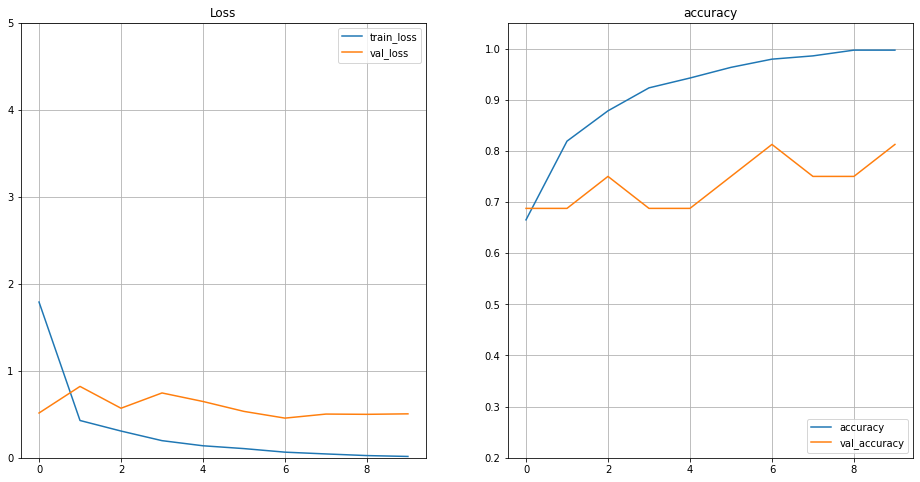

In [14]:
#@title Plot loss + Acc 
pname = os.path.join(path, 'res')
plot_history(history.history, ['accuracy'], pname, 1,2)


[[233   1]
 [  0 390]]


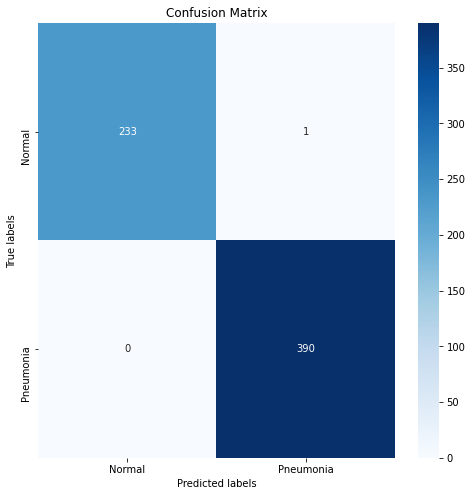

In [15]:
#@title Plot confusion matrix
cmname = os.path.join(path, 'cm.png')

prediction = model.predict(imgs)

cm = confusion_matrix(classes, np.round(prediction))
print(cm.astype(int))


fig, ax = plt.subplots(1, 1, figsize = (8,8))

sns.heatmap(cm, annot=True,cmap='Blues', fmt='g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
fig.savefig(cmname)